## Test the segmentation of the images using OpenCV
#### Segmentation is done on a preprocessed image, where a proper threshold has been applied

In [1]:
import cv2
import numpy as np
import tqdm
import matplotlib.pyplot as plt
from cv2 import cvtColor, COLOR_BGR2RGB

dataset_path = '../dataset/'
test_pictures_path = dataset_path + 'tif_merged_processed/'

In [2]:
picture = '1w_D Merged_Processed.tif'
picture_path = test_pictures_path + picture

______________________________

In [3]:
img = cv2.imread(picture_path, cv2.IMREAD_GRAYSCALE)
assert img is not None, 'No image found.'   # asert check if true, otherwise raise an AssertionError with an optional error message

### Proper thresholding to estimate the follicles

source: https://docs.opencv.org/3.4/d7/d4d/tutorial_py_thresholding.html

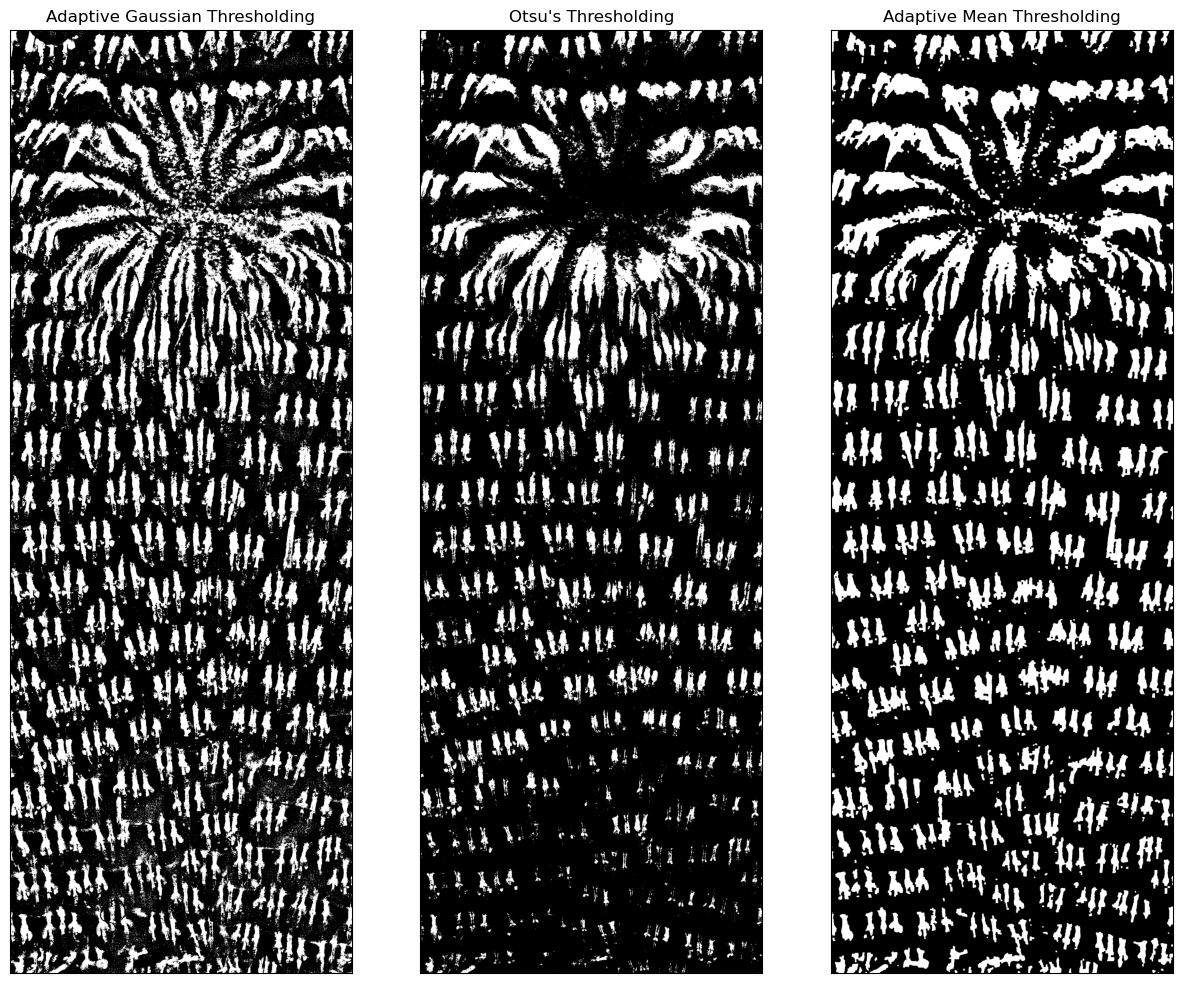

In [97]:
#Adaptive gaussian
thresh1 = cv2.adaptiveThreshold(img, 150, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 201, 0)
#Otsu's binarization
thresh2 = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
#Adaptive mean
thresh3 = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 241, 0)

# remove noise from thresh3
kernel = np.ones((5,5),np.uint8)
thresh3 = cv2.morphologyEx(thresh3, cv2.MORPH_OPEN, kernel, iterations=1)
thresh3 = cv2.morphologyEx(thresh3, cv2.MORPH_CLOSE, kernel, iterations=1)




plt.figure(figsize=(15,15))
plt.subplot(131), plt.imshow(thresh1, cmap='gray')
plt.title('Adaptive Gaussian Thresholding'), plt.xticks([]), plt.yticks([])
plt.subplot(132), plt.imshow(thresh2, cmap='gray')
plt.title("Otsu's Thresholding"), plt.xticks([]), plt.yticks([])
plt.subplot(133), plt.imshow(thresh3, cmap='gray')
plt.title("Adaptive Mean Thresholding"), plt.xticks([]), plt.yticks([])
plt.show()


Now we must remove the noise using morphological opening. By doing this we can define a "sure background", a "sure foreground" and an "unknown" region

source: https://docs.opencv.org/4.x/d3/db4/tutorial_py_watershed.html

morphological transformations: https://docs.opencv.org/3.4/d9/d61/tutorial_py_morphological_ops.html

100%|██████████| 665/665 [00:01<00:00, 480.40it/s]


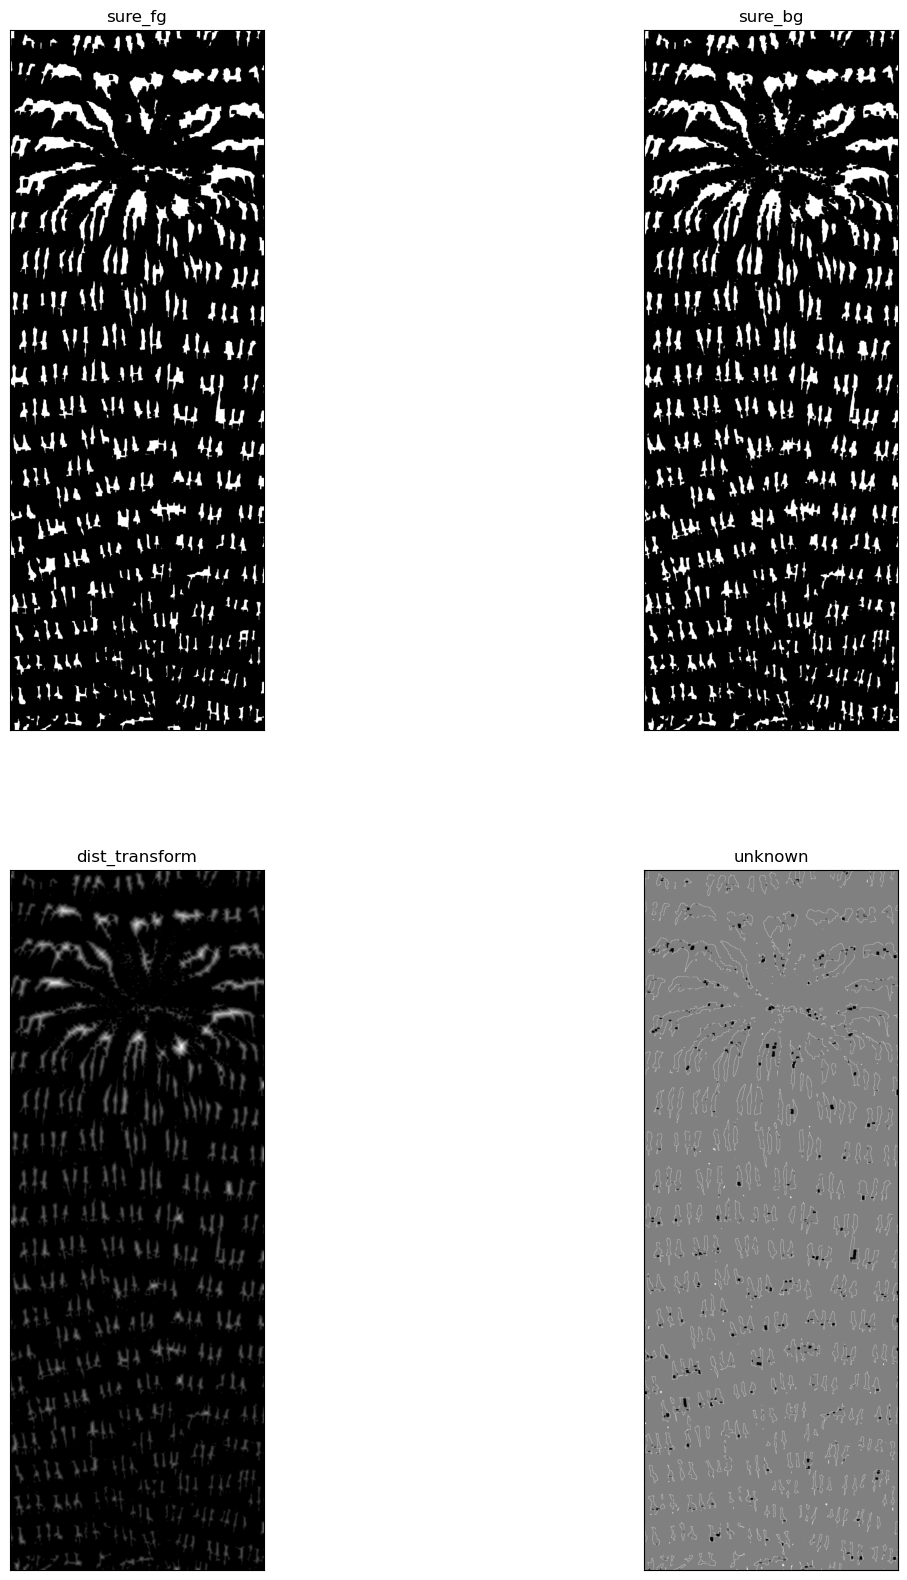

In [142]:
# Parameters one can tune
close_iterations = 4            # for morphological closing
open_iterations = 2             # for morphological opening
erode_iterations = 4               # for morphological erosion
dilate_interations = 2              # for morphological dilation

dist_transform_parameter = 0.0001      # for distance transform
metric = cv2.DIST_C                # cv2.DIST_L1 (Manhattan distance), 
                                    # cv2.DIST_L2 (Euclidean distance),
                                    # cv2.DIST_C  (Chebyshev distance)
distance_transform_mask_size = 3    # 3 or 5
max_sure_fg = 40
thresholding_type = cv2.THRESH_BINARY                                                   
#########################################################################################



# noise removal
kernel = np.ones((3, 3), np.uint8)                                                                      # 1x1 kernel with full of ones
open = cv2.morphologyEx(thresh3, cv2.MORPH_OPEN, kernel, iterations=open_iterations)                    # opening = erosion followed by dilation, useful in removing noise

# sure background area
sure_bg = cv2.dilate(open, kernel, iterations=1)                         # dilate = adds pixels to the boundaries of objects in an image
sure_bg = cv2.erode(sure_bg, kernel, iterations=erode_iterations)                         # erode = removes pixels at the boundaries of objects in an image

# sure foreground area
dist_transform = cv2.distanceTransform(thresh3, metric, distance_transform_mask_size)                    # distanceTransform calculates the approximate or precise distance from every binary image pixel to the nearest zero pixel
ret, sure_fg = cv2.threshold(dist_transform, dist_transform_parameter * dist_transform.max(), max_sure_fg, thresholding_type)  # thresholding the distance transform image to obtain regions of sure foreground

# Finding unknown region
sure_fg = np.uint8(sure_fg)

# remove small objects from thresh3
nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(sure_fg, connectivity=8)
sizes = stats[1:, -1]; nb_components = nb_components - 1
min_size = 300
img2 = np.zeros((output.shape))
for i in tqdm.tqdm(range(0, nb_components)):
    if sizes[i] >= min_size:
        img2[output == i + 1] = 255
sure_fg = img2

#remove noise from sure_fg
kernel = np.ones((5,5),np.uint8)
sure_fg = cv2.morphologyEx(sure_fg, cv2.MORPH_OPEN, kernel, iterations=2)
sure_fg = cv2.morphologyEx(sure_fg, cv2.MORPH_CLOSE, kernel, iterations=2)
sure_fg = cv2.morphologyEx(sure_fg, cv2.MORPH_ERODE, kernel, iterations=2)

unknown = cv2.subtract(sure_bg.astype(np.int32), sure_fg.astype(np.int32)) # show sure_fg, sure_bg, dist_transform, unknown one next to the other

plt.figure(figsize=(15, 20))
plt.subplot(221), plt.imshow(sure_fg, cmap='gray')
plt.title('sure_fg'), plt.xticks([]), plt.yticks([])
plt.subplot(222), plt.imshow(sure_bg, cmap='gray')
plt.title('sure_bg'), plt.xticks([]), plt.yticks([])
plt.subplot(223), plt.imshow(dist_transform, cmap='gray')
plt.title('dist_transform'), plt.xticks([]), plt.yticks([])
plt.subplot(224), plt.imshow(unknown, cmap='gray')
plt.title('unknown'), plt.xticks([]), plt.yticks([])
plt.show()


### Marker labelling and Watershed algorithm

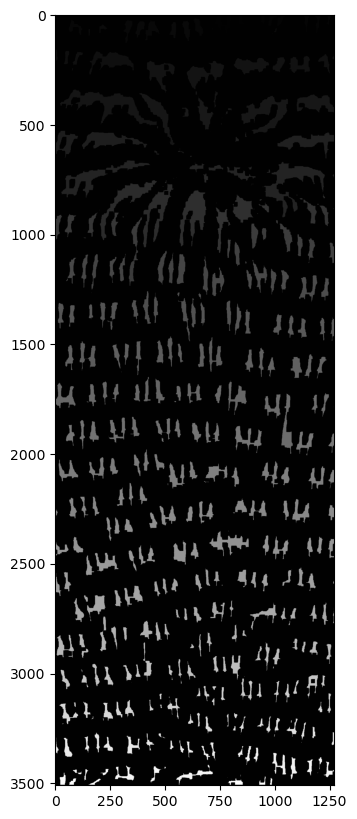

In [143]:
# Ensure sure_fg has the correct data type (8-bit unsigned integer)
sure_fg = sure_fg.astype(np.uint8)

# Use connectedComponents
markers = cv2.connectedComponents(sure_fg)
markers = markers[1] + 1  # Retrieve labels and add 1 to all labels

# Mark the region of unknown with zero
markers[unknown == 255] = 0

# Watershed algorithm
markers = cv2.watershed(cv2.cvtColor(img, cv2.COLOR_GRAY2BGR), markers)

# Display the result
plt.figure(figsize=(10, 10))
plt.imshow(markers, cmap='gray')
plt.show()

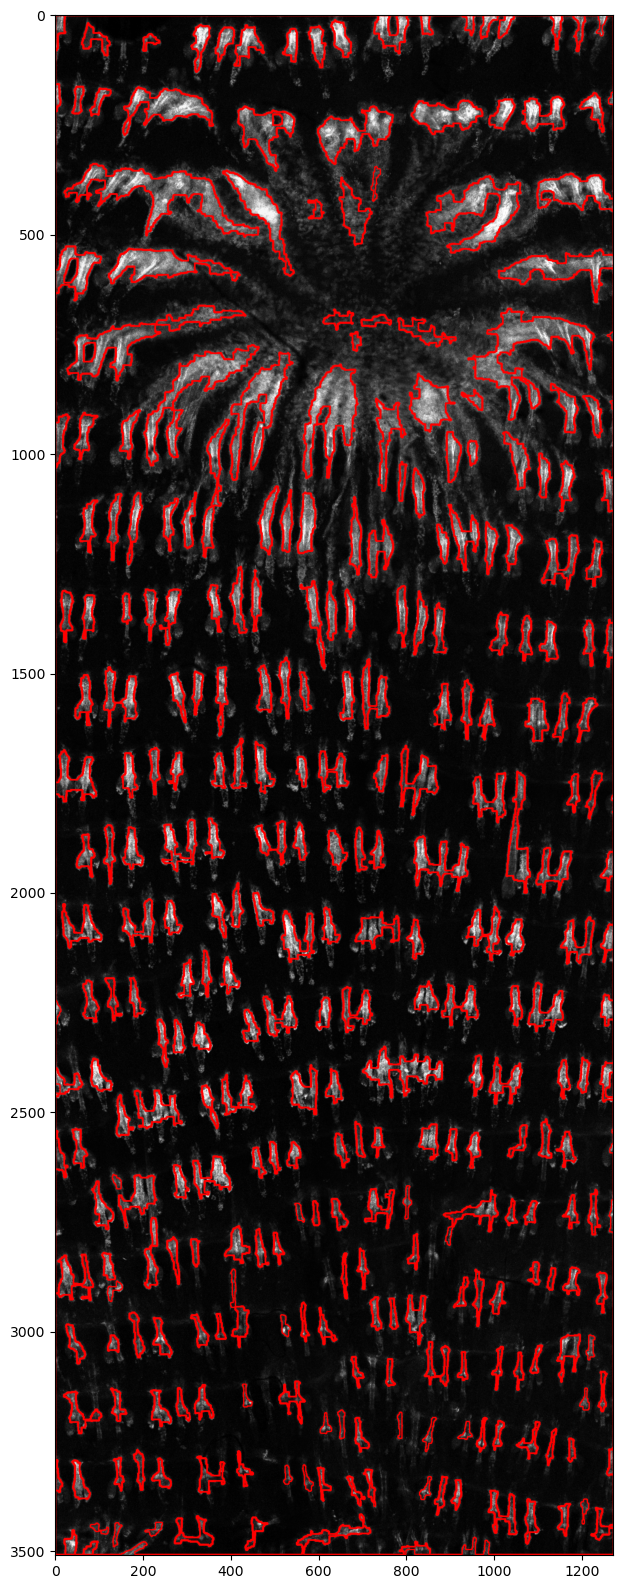

Number of cells:  831


In [144]:
# contouring the original image
img2 = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
contours, hierarchy = cv2.findContours(markers.copy(), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)   # findContours = finds contours in a binary image

# Define a threshold area for contour filtering (adjust as needed)
min_contour_area = 400

for i in range(len(contours)):
    if hierarchy[0][i][3] == -1:  # If there is no child contour
        # Calculate the area of the contour
        contour_area = cv2.contourArea(contours[i])

        # Check if the contour area is above the threshold
        if contour_area > min_contour_area:
            cv2.drawContours(img2, contours, i, (255, 0, 0), 2)

plt.figure(figsize=(20, 20))
plt.imshow(img2)
plt.show()

print('Number of cells: ', len(contours))